In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

In [2]:
water_data = pd.read_csv('data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
# В данных есть пропуски. Выведем информацию о них в процентном соотношении:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

Итак, у нас отсутствует около 15 % информации о кислотности воды (ph), около 24 % — о содержании сульфатов (Sulfate) и около 5 % — о тригалометанах (Trihalomethanes). Мы знаем, что пропуски — непосильная ноша для большинства моделей машинного обучения. Их необходимо обработать.

Заполним пропуски медианным значением в признаке зависимости класса воды (Potability). Для этого сгруппируем данные по признаку Potability, посчитаем медиану в каждой группе, а затем отправим результат в метод fillna():

In [4]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [5]:
display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

## Двухкомпонентный подход

In [6]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

In [7]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (2620, 9)
Valid shape: (656, 9)


В качестве модели будем использовать дерево решений с максимальной глубиной 7, энтропией в качестве критерия информативности, минимальное число объектов в листе дерева — 5.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — accuracy.

In [8]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


## Трёхкомпонентный подход

Если же мы используем трёхкомпонентный подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), тут нам понадобится чуть больше кода. К сожалению, в sklearn нет специализированного функционала для такого разбиения.

In [9]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


## K-FOLD валидация

В библиотеке sklearn метод k-fold реализован в классе KFold.
Основные параметры инициализатора KFold:

* n_split —  число фолдов (число  из метода k-fold). По умолчанию — 5.
* shuffle — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — False.
* random_state — число, на основе которого производится генерация случайных чисел, если набор данных будет перемешиваться.

У объекта класса KFold есть метод split(). В данный метод необходимо передать матрицу наблюдений X и вектор-столбец ответов y — метод вернёт генератор, который позволит получать индексы тренировочной и валидационной выборок, сгенерированных по методу k-fold.

Будем использовать двухкомпонентный контроль, то есть подавать в кросс-валидацию весь доступный набор данных без предварительного выделения тестовой выборки.

Создадим объект KFold для кросс-валидации с пятью фолдами, остальные параметры оставим по умолчанию. Затем организуем цикл for для получения элементов из генератора, созданного с помощью метода split(). На каждой итерации в переменных train_index и valid_index будут находиться индексы текущей тренировочной и валидационной выборок соответственно.

В цикле будем:

выделять строки таблицы, относящиеся к текущим тренировочной и валидационной выборкам, в отдельные таблицы;
обучать дерево решений;
делать предсказания для текущих тренировочной и валидационной выборок;
рассчитывать метрику accuracy на текущих выборках и заносить её значение в список.

In [10]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем случайный лес на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [11]:
print(train_metrics)
print(val_metrics)

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


В каждом из выведенных списков содержится по пять значений метрики accuracy, вычисленных на тренировочном и валидационном фолдах кросс-валидации. Для агрегированной оценки рассчитаем среднее значение метрик:

In [12]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


**Примечание.** Если количество фолдов больше 30, вы можете построить доверительный интервал для среднего значения метрики.

На самом весь приведённый выше код можно значительно сократить, если использовать специальную функцию для кросс-валидации — cross_validate() из модуля model_selection. Она организует процедуру кросс-валидации и расчёт метрик.

Основные параметры функции cross_validate():

* estimator — модель, качество которой будет проверяться на кросс-валидации.
* X — матрица наблюдений.
* y — вектор-столбец правильных ответов.
* cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
* scoring — название метрики в виде строки либо функция для её вычисления ('accuracy', 'precision', 'recall', 'f1' и другие; полный список — в документации к функции).
* return_train_score — параметр, указывающий стоит ли возвращать значения метрики, полученных на тренировочных фолдах. По умолчанию — False, то есть метрики считаются только на валидационных фолдах.

Функция возвращает словарь со следующими ключами:

* fit_time — время обучения модели на каждой итерации кросс-валидации;
* score_time — время вычисления метрик на каждой итерации кросс-валидации;
* test_score — значения метрик на валидационных фолдах;
* train_score — значения метрик на тренировочных фолдах.

In [13]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.03100276, 0.02699375, 0.02698183, 0.02615809, 0.02598333]),
 'score_time': array([0.00099945, 0.00100136, 0.00100231, 0.00203276, 0.00200152]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

In [14]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


## LEAVE-ONE-OUT

Метод leave-one-out (отложенный пример), или поэлементная кросс-валидация — это частный случай кросс-валидации (k-fold), когда размер  равняется размеру всей выборки , где  — количество примеров (строк в таблице).


In [15]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


**Примечание.** Метод leave-one-out можно реализовать и без использования специального класса — достаточно просто указать параметр n_split=n в инициализаторе KFold, где n — количество строк в таблице.

# 3. Дисбаланс выборки

0    0.60989
1    0.39011
Name: Potability, dtype: float64

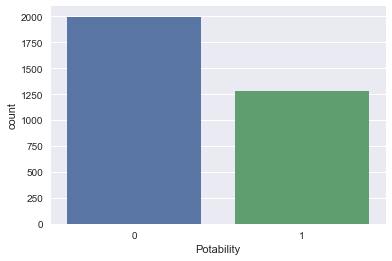

In [16]:
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

## СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ

In [17]:
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.620229
1    0.379771
Name: Potability, dtype: float64
Valid:
0    0.568598
1    0.431402
Name: Potability, dtype: float64


In [18]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Valid:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


Для этого вместо KFold используется кросс-валидатор StratifiedKFold. Принцип работы с ним аналогичен, только, в отличие от KFold, StratifiedKFold будет разбивать выборку на части таким образом, чтобы в тренировочных и валидационных фолдах соотношения классов были приблизительно одинаковыми.

In [19]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Valid:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


 ## ML-5 Задание 3.3

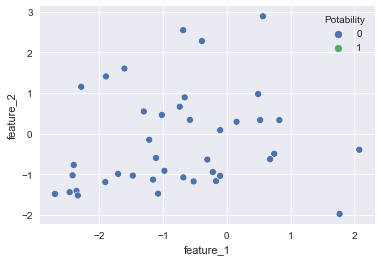

In [20]:
from sklearn import datasets
X_33, y_33 = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X_33 = pd.DataFrame(X_33, columns=['feature_1', 'feature_2'])
y_33 = pd.Series(y_33)

X_train_33, X_valid_33, y_train_33, y_valid_33 = model_selection.train_test_split(X_33, y_33, stratify=y_33, test_size=0.2, random_state=42)

sns.scatterplot(x=X_valid_33['feature_1'], y=X_valid_33['feature_2'], hue=y);

In [21]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=40, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred)) 

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.66       256

    accuracy                           0.77       656
   macro avg       0.79      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



In [22]:
# X_train_33, X_valid_33, y_train_33, y_valid_33 = model_selection.train_test_split(X_33, y_33, stratify=y_33, test_size=0.2, random_state=42)
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    # solver='sag', #алгоритм оптимизации
    # random_state=42 # , #генератор случайных чисел
    # max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_33, y_train_33)

LogisticRegression()

In [23]:
#Делаем предсказание для тренировочной выборки
y_train_pred_33 = log_reg.predict(X_train_33)

#Делаем предсказание для каждой из выборок
y_train_pred_33 = log_reg.predict(X_train_33)
y_valid_pred_33 = log_reg.predict(X_valid_33)
#Выводим значения метрик
print(metrics.classification_report(y_valid_33, y_valid_pred_33)) 

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



## ВЗВЕШИВАНИЕ ОБЪЕКТОВ

Большинство моделей, реализованных в sklearn, имеют параметр class_weight — веса классов. Чтобы сбалансировать важность классов, обычно берут веса объектов класса-большинства (мажоритарного класса) равным

а веса объектов малочисленного (миноритарного) класса вычисляются по следующей формуле:

где  и  число — объектов в миноритарном и мажоритарном классах соответственно. Подобная установка весов заставляет алгоритм обращать большее внимание на объекты менее популярного класса.

Для того чтобы задать веса классам по приведённым выше формулам, достаточно в инициализаторе модели выставить параметр class_weight='balanced'.

In [24]:
#Создаём модель
model_b = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model_b.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_b.predict(X_train)
y_valid_pred = model_b.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.63      0.76      0.69       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



In [25]:
# class_weight='balanced'

#Создаем объект класса логистическая регрессия
log_reg_b = linear_model.LogisticRegression(
    # solver='sag', #алгоритм оптимизации
    # random_state=42 # , #генератор случайных чисел
    # max_iter=1000 #количество итераций на сходимость
    class_weight='balanced'
)
#Обучаем модель, минимизируя logloss
log_reg_b.fit(X_train_33, y_train_33)

#Делаем предсказание для каждой из выборок
y_train_pred_33_b = log_reg_b.predict(X_train_33)
y_valid_pred_33_b = log_reg_b.predict(X_valid_33)
#Выводим значения метрик
print(metrics.classification_report(y_valid_33, y_valid_pred_33_b)) 


              precision    recall  f1-score   support

           0       0.97      0.83      0.90        36
           1       0.33      0.75      0.46         4

    accuracy                           0.82        40
   macro avg       0.65      0.79      0.68        40
weighted avg       0.90      0.82      0.85        40



In [26]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


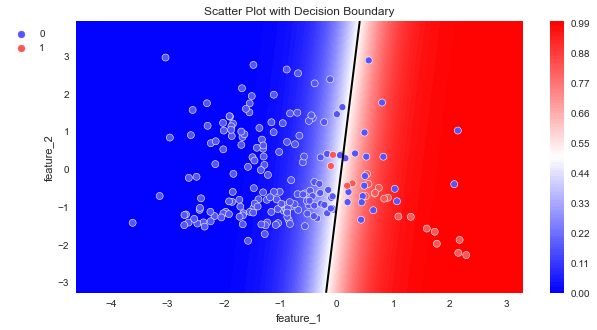

In [27]:
plot_probabilities_2d(X_33, y_33, log_reg_b)

## PR-кривая (precision-recall curve) — это график зависимости precision от recall при различных значениях порога вероятности.

Качество определяется площадью (PR AUC) под кривой: чем ближе значение площади к 1, тем лучше модель. Идеальная модель — та, у которой площадь равна 1. У такой модели и precision, и recall равны 1. Конечно же, таких моделей не существует в природе.

Если площадь под PR-кривой меньше 0.5, модель считается очень слабой (качество её распознавания хуже, чем подбрасывание монетки).

Перед построением PR-кривой нам необходимо предсказать вероятности принадлежности к классу 1 на валидационных фолдах кросс-валидации.

Для предсказания вероятностей используем функцию cross_val_predict(). Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр method='predict_proba', она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции cross_validate().

In [28]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
y_cv_proba_pred

array([[0.        , 1.        ],
       [0.24561404, 0.75438596],
       [1.        , 0.        ],
       ...,
       [0.60621762, 0.39378238],
       [1.        , 0.        ],
       [0.03030303, 0.96969697]])

Это массив из вероятностей для каждого образца воды. Первое число в строке — вероятность того, что данный образец является непригодным для питья, а второе — вероятность того, что данный образец пригоден для питья.

In [29]:
#Выделяем столбец с вероятностями для класса 1. Это второй столбец в матрице вероятностей (индекс 1).
y_cv_proba_pred = y_cv_proba_pred[:, 1]

Теперь мы можем построить PR-кривую. Для этого воспользуемся функций precision_recall_curve() из модуля metrics библиотеки sklearn. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен она вернёт три массива: значения метрик precision и recall, вычисленных на различных порогах вероятности, и сами пороги вероятности:

In [30]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


Осталось дело за малым. Вычислим значение -score при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна. Сделать это можно с помощью функции argmax() из модуля numpy — она возвращает индекс максимального элемента массива.

Best threshold = 0.33, F1-Score = 0.69


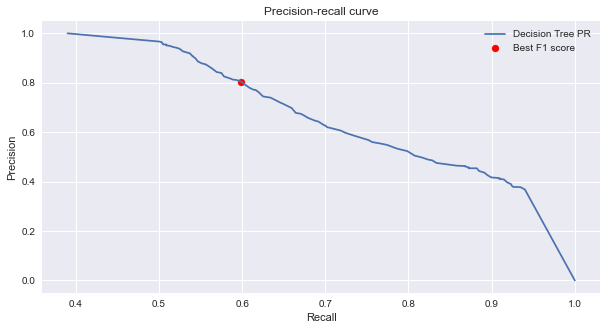

In [31]:
# Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
# Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
# Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) # фигура + координатная плоскость
# Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
# Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='red', label='Best F1 score')
# Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
# Отображаем легенду
ax.legend();

Итак, согласно нашим вычислениям и построенной PR-кривой, максимум  (0.69) на кросс-валидации наблюдается при пороге вероятности 0.33.

Сделаем предсказание классов с таким порогом для всех объектов из отложенной валидационной выборки и выведем отчёт о метриках:

In [32]:
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
threshold_opt = thresholds[idx]
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.62      0.76      0.68       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



**Примечание.** Чтобы вычислить площадь под PR-кривой, используется функция auc() из модуля metrics библиотеки sklearn. В данную функцию нужно передать значения метрик recall и precision при различных порогах вероятности:

In [33]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.79


## СЭМПЛИРОВАНИЕ

А точнее — пересэмплирование (oversampling).  Идея очень проста: если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество.

### SMOTE (Synthetic Minority Oversampling Techniques)

Алгоритмов сэмплирования, в том числе SMOTE, нет в стандартном пакете sklearn — они содержатся в библиотеке imblearn (imbalanced-learn).

In [35]:
# !pip install imbalanced-learn --user 

# Для пользователей anaconda:
# %conda update conda
# %conda install -c conda-forge imbalanced-learn 

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

## Package Plan ##

  environment location: c:\ProgramData\Anaconda3

  added / updated specs:
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.9.24  |       h5b45459_0         189 KB  conda-forge
    certifi-2022.9.24          |     pyhd8ed1ab_0         155 KB  conda-forge
    conda-4.14.0               |   py39hcbf5309_0         1.0 MB  conda-forge
    imbalanced-learn-0.9.1     |     pyhd8ed1ab_1         115 KB  conda-forge
    jupyter_core-4.11.1        |   py39hcbf5309_0         106 KB  conda-forge
    openssl-1.1.1q             |       h8ffe710_0         5.8 MB  conda-forge
    pandas-1.4.3               |   py39h2e25243_0        11.0 MB  conda-forge
    pip-22.2.2                 |     pyhd8ed1ab_0         1.5 MB  conda-forge
    p


The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/win-64::anaconda-client==1.9.0=py39haa95532_0
  - defaults/win-64::anaconda==custom=py39_1
  - defaults/win-64::anaconda-navigator==2.2.0=py39haa95532_0
  - defaults/noarch::anaconda-project==0.10.1=pyhd3eb1b0_0
  - defaults/win-64::astropy==4.3.1=py39hc7d831d_0
  - defaults/win-64::bcrypt==3.2.0=py39h196d8e1_0
  - defaults/win-64::bkcharts==0.2=py39haa95532_0
  - defaults/noarch::conda-repo-cli==1.0.4=pyhd3eb1b0_0
  - defaults/noarch::dask==2021.10.0=pyhd3eb1b0_0
  - defaults/noarch::datashader==0.13.0=pyhd3eb1b0_1
  - defaults/win-64::gensim==3.8.3=py39hd77b12b_2
  - defaults/noarch::holoviews==1.14.8=pyhd3eb1b0_0
  - defaults/noarch::hvplot==0.7.3=pyhd3eb1b0_1
  - defaults/noarch::intake==0.6.5=pyhd3eb1b0_0
  - defaults/win-64::ipykernel==6.4.1=py39haa95532_1
  - defaults/noarch::ipywidgets==7.6.5=pyhd3eb1b0_1
  - defaults/win-64::jupyter==1.0

conda-4.14.0         | 1.0 MB    | #######    |  70% 
conda-4.14.0         | 1.0 MB    | ########## | 100% 

pip-22.2.2           | 1.5 MB    |            |   0% 
pip-22.2.2           | 1.5 MB    | ####       |  41% 
pip-22.2.2           | 1.5 MB    | ########## | 100% 
pip-22.2.2           | 1.5 MB    | ########## | 100% 

imbalanced-learn-0.9 | 115 KB    |            |   0% 
imbalanced-learn-0.9 | 115 KB    | #3         |  14% 
imbalanced-learn-0.9 | 115 KB    | ########## | 100% 
imbalanced-learn-0.9 | 115 KB    | ########## | 100% 

scipy-1.7.3          | 13.9 MB   |            |   0% 
scipy-1.7.3          | 13.9 MB   |            |   0% 
scipy-1.7.3          | 13.9 MB   | 1          |   1% 
scipy-1.7.3          | 13.9 MB   | 2          |   3% 
scipy-1.7.3          | 13.9 MB   | 5          |   5% 
scipy-1.7.3          | 13.9 MB   | #          |  10% 
scipy-1.7.3          | 13.9 MB   | #8         |  18% 
scipy-1.7.3          | 13.9 MB   | ##6        |  26% 
scipy-1.7.3          | 13

Примечание. Если вы используете среду Anaconda, у вас может возникнуть следующая ошибка при импорте библиотеки imblearn:

ImportError: cannot import name '_euclidean_distances' from 'sklearn.metrics.pairwise'
В этом случае обновите пакеты Anaconda:

conda update conda
После этого произведите установку пакета ещё раз:

!conda install -c conda-forge imbalanced-learn

In [36]:
from imblearn.over_sampling import SMOTE

<frozen importlib._bootstrap>:228: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


In [37]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
0    1598
1    1022
Name: Potability, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
0    1598
1    1598
Name: Potability, dtype: int64


In [38]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



### Задание 3.11

Для выполнения этого задания используйте сгенерированные тренировочную и валидационную выборки из задания 3.3.

Сбалансируйте тренировочную выборку с помощью алгоритма SMOTE. В качестве значения параметра random_state возьмите число 42, остальные параметры оставьте по умолчанию.

Обучите модель логистической регрессии на пересэмплированной тренировочной выборке. Все параметры оставьте по умолчанию.

Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

In [39]:
sm = SMOTE(random_state=42)
X_train_s, y_train_s = sm.fit_resample(X_train_33, y_train_33)
X_valid_s, y_valid_s = sm.fit_resample(X_valid_33, y_valid_33)

#Создаем объект класса логистическая регрессия
log_reg_s = linear_model.LogisticRegression()

#Обучаем модель, минимизируя logloss
log_reg_s.fit(X_train_s, y_train_s)

#Делаем предсказание для каждой из выборок
y_train_pred_33_s = log_reg_s.predict(X_train_s)
y_valid_pred_33_s = log_reg_s.predict(X_valid_s)
#Выводим значения метрик
print(metrics.classification_report(y_valid_33, y_valid_pred_33_s)) 

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 6